In [1]:
!git clone https://github.com/SalesforceAIResearch/uni2ts.git
%cd uni2ts
!pip install .


Cloning into 'uni2ts'...
remote: Enumerating objects: 847, done.
remote: Counting objects: 100% (365/365), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 847 (delta 253), reused 221 (delta 220), pack-reused 482 (from 1)
Receiving objects: 100% (847/847), 5.25 MiB | 30.74 MiB/s, done.
Resolving deltas: 100% (410/410), done.
/kaggle/working/uni2ts
Processing /kaggle/working/uni2ts
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.8/153.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

In [42]:
import pandas as pd
from gluonts.dataset.pandas import PandasDataset

# Load the ETTh1 dataset from Kaggle
# (Replace with the correct path to "ETTh1.csv" if stored in Kaggle's datasets directory)
df = pd.read_csv('/kaggle/input/etthigh/ETTh1.csv', index_col = 0, parse_dates = True)
#df = df.drop(['HULL', 'MUFL', 'MULL', 'OT'], axis=1)
print(df)

ds = PandasDataset(dict(df))

                       HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
date                                                                     
2016-07-01 00:00:00   5.827  2.009  1.599  0.462  4.203  1.340  30.531000
2016-07-01 01:00:00   5.693  2.076  1.492  0.426  4.142  1.371  27.787001
2016-07-01 02:00:00   5.157  1.741  1.279  0.355  3.777  1.218  27.787001
2016-07-01 03:00:00   5.090  1.942  1.279  0.391  3.807  1.279  25.044001
2016-07-01 04:00:00   5.358  1.942  1.492  0.462  3.868  1.279  21.948000
...                     ...    ...    ...    ...    ...    ...        ...
2018-06-26 15:00:00  -1.674  3.550 -5.615  2.132  3.472  1.523  10.904000
2018-06-26 16:00:00  -5.492  4.287 -9.132  2.274  3.533  1.675  11.044000
2018-06-26 17:00:00   2.813  3.818 -0.817  2.097  3.716  1.523  10.271000
2018-06-26 18:00:00   9.243  3.818  5.472  2.097  3.655  1.432   9.778000
2018-06-26 19:00:00  10.114  3.550  6.183  1.564  3.716  1.462   9.567000

[17420 rows x 7 columns]


In [54]:
import torch
import matplotlib.pyplot as plt
from gluonts.dataset.split import split
from huggingface_hub import hf_hub_download

from uni2ts.eval_util.plot import plot_single, plot_next_multi
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule

# Define Moirai model parameters
SIZE = "small"  # model size: choose from {'small', 'base', 'large'}
PDT = 20        # prediction length: any positive integer
CTX = 200       # context length: any positive integer
PSZ = "auto"    # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 32        # batch size: any positive integer
TEST = 100      # test set length: any positive integer

# Split into train and test sets
train, test_template = split(ds, offset=-TEST)  # last TEST time steps are test set

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,    # non-overlapping windows
    distance=PDT
)

model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-small"),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
)

# Create predictor and forecast
predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_list = list(test_data.input)
label_list = list(test_data.label)
forecast_list = list(forecasts)


In [56]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

input_it = iter(input_list)
label_it = iter(label_list)
forecast_it = iter(forecast_list)

total_mse = 0
total_mae = 0
cnt = 0

for inp, label, forecast in zip(input_it, label_it, forecast_it):
    y_true = np.array(label['target'])      # Actual values
    y_pred = np.array(forecast['median'])   # Forecasted mean values

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    
    cnt += 1
    total_mse += mse
    total_mae += mae

print(total_mse / cnt)
print(total_mae / cnt)


6.74641871386886
1.4018393363484314


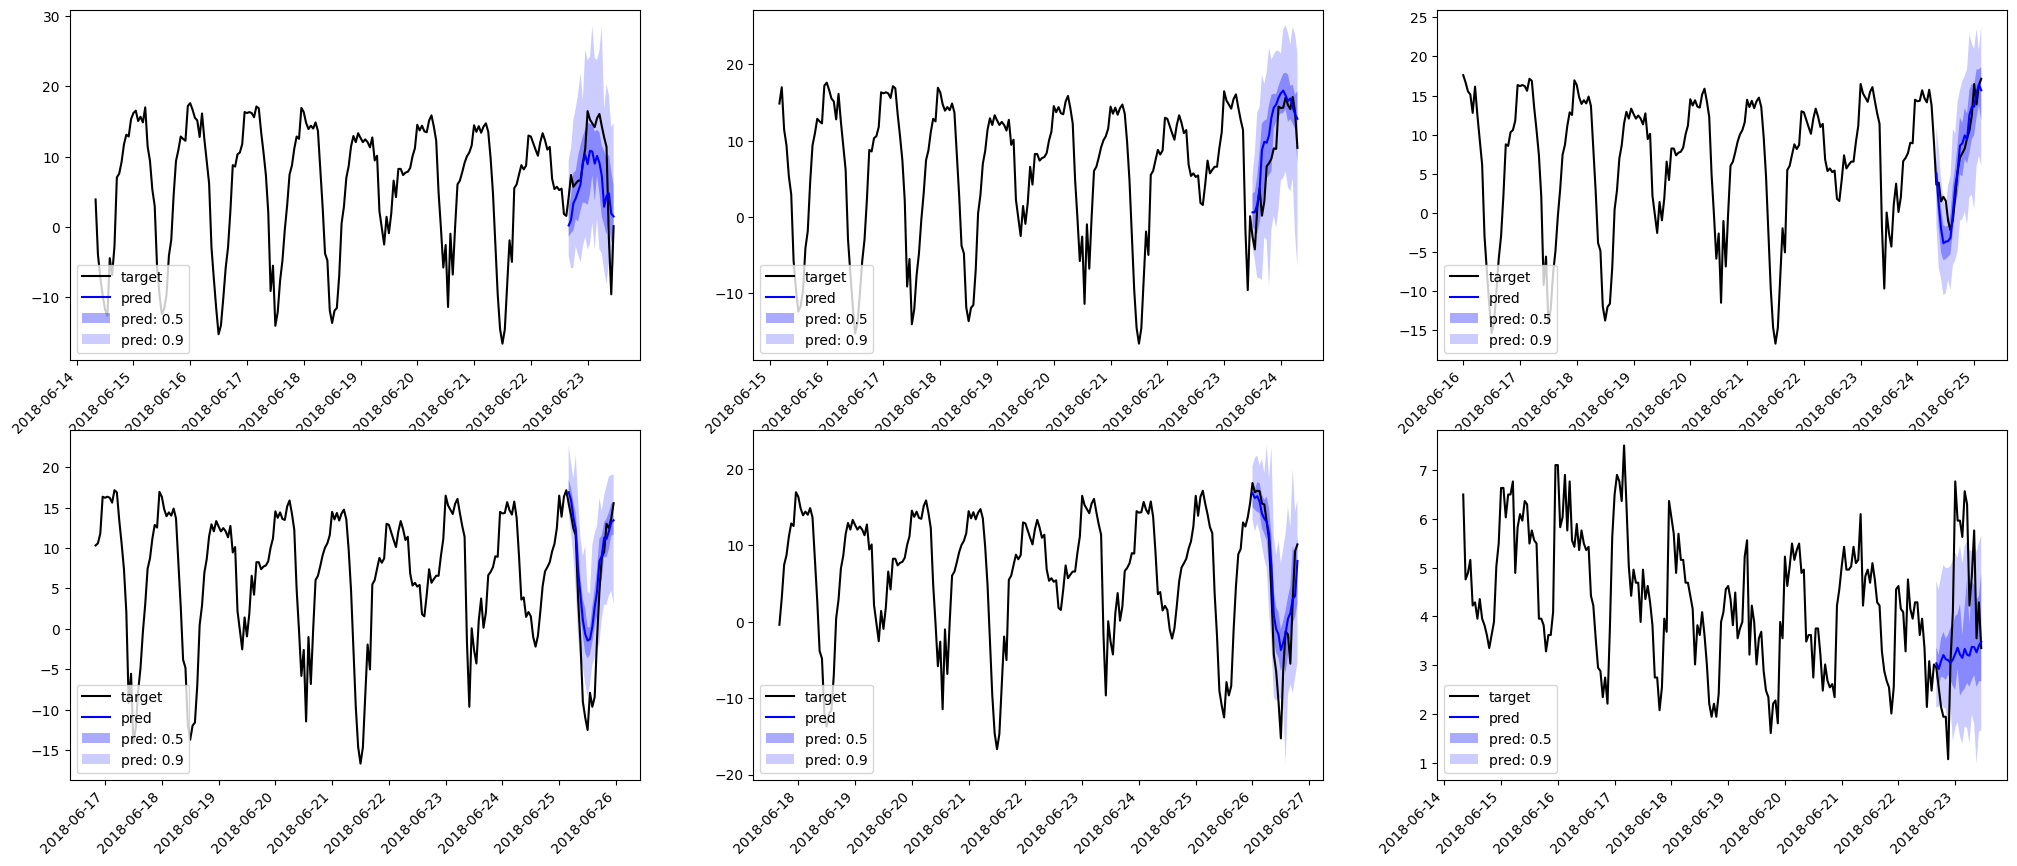

In [57]:
input_it = iter(input_list)
label_it = iter(label_list)
forecast_it = iter(forecast_list)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
plot_next_multi(
    axes,
    input_it,
    label_it,
    forecast_it,
    context_length=200,
    intervals=(0.5, 0.9),
    dim=None,
    name="pred",
    show_label=True,
)